In [1]:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from rasterio.io import MemoryFile

In [5]:
TENSOR_PATH = Path("datasets/sentinel")
OUTPUT_PATH = Path("datasets/ndvi")
RED_LAYER = 1
NIR_LAYER = 4

In [79]:
def add_ndvi(tensor):
    """Add NDVI layer to tensor"""
    with rio.open(tensor) as src:
        red = src.read(RED_LAYER)
        nir = src.read(NIR_LAYER)
        ndvi = np.divide((nir - red), (nir + red))

        # replace pixels in the NDVI layer with the NO DATA value where such a value is present in the NIR or red layer
        ndvi[np.logical_or(nir == src.nodata, red == src.nodata)] = src.nodata

        # add the NDVI layer to the tensor geotiff in a new memfile
        meta = src.meta.copy()
        meta.update(count=src.count + 1)

        memfile = MemoryFile()
        with memfile.open(**meta) as dst:
            # Write all existing bands to the new file
            for i in range(1, src.count + 1):
                dst.write(src.read(i), i)

            # Write the NDVI layer as the last band
            dst.write(ndvi, src.count + 1)

    return memfile



In [80]:
# Create output directory if it does not exist
OUTPUT_PATH.mkdir(exist_ok=True)

# Iterate over all tensors
for tensor in TENSOR_PATH.iterdir():
    # Add NDVI layer to tensor
    with add_ndvi(tensor) as memfile:
        # Write the new tensor to disk
        output_path = OUTPUT_PATH / tensor.name
        with output_path.open("wb") as f:
            f.write(memfile.read())

        print(f"Written {output_path}")

Written datasets\ndvi\CANOLA_02038a28-b22b-49ea-aa2b-7d12df8899be_2020255.tif
Written datasets\ndvi\CANOLA_09b11302-014d-4512-b3fc-9253b7b9ebdf_2018236.tif
Written datasets\ndvi\CANOLA_09b11302-014d-4512-b3fc-9253b7b9ebdf_2020242.tif
Written datasets\ndvi\CANOLA_18c90f81-79f3-494c-97a2-5a3475029d4f_2017248.tif
Written datasets\ndvi\CANOLA_18c90f81-79f3-494c-97a2-5a3475029d4f_2021257.tif


KeyboardInterrupt: 

In [29]:
path = Path("datasets/ndvi/CANOLA_18c90f81-79f3-494c-97a2-5a3475029d4f_2017248.tif")

with rio.open(path) as src:
    ndvi = src.read(5)
    # check for nans and inf values
    print(f"Number of nan values in NDVI layer: {np.sum(np.isnan(ndvi))}")
    print(f"Number of inf values in NDVI layer: {np.sum(np.isinf(ndvi))}")

Number of nan values in NDVI layer: 0
Number of inf values in NDVI layer: 0


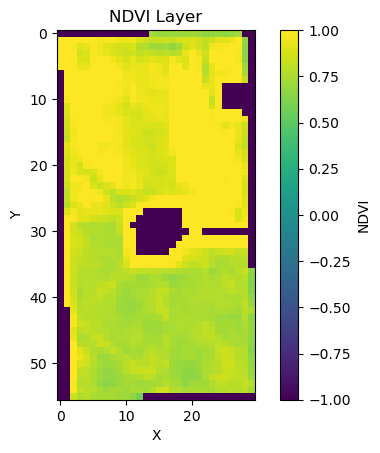

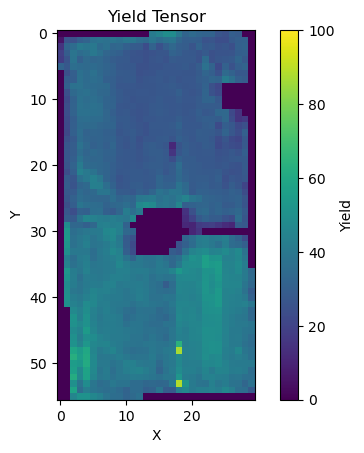

In [9]:
# Plot the NDVI layer of the first tensor
with rio.open(OUTPUT_PATH / "CANOLA_1a3e0bf5-44df-4b8e-b56f-7ae25295147f_2018227.tif") as src:
    ndvi = src.read(src.count)
    plt.imshow(ndvi, cmap="viridis", vmin=-1, vmax=1)
    plt.colorbar(label="NDVI")
    plt.title("NDVI Layer")
    plt.xlabel("X")
    plt.ylabel("Y")

plt.show()

# plot the corresponding yield tensor
with rio.open(Path("datasets", "yields") / "CANOLA_1a3e0bf5-44df-4b8e-b56f-7ae25295147f_2018227.tif") as src:
    plt.imshow(src.read(1), cmap="viridis", vmin=0, vmax=100)
    plt.colorbar(label="Yield")
    plt.title("Yield Tensor")
    plt.xlabel("X")
    plt.ylabel("Y")

plt.show()